<a href="https://colab.research.google.com/github/dorapapp96/test_task/blob/main/test_task_PD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import savgol_filter
import scipy
import math
from sklearn.cluster import KMeans
from scipy.signal import find_peaks

# Read data from files
In spacedata5 an error occured while reading, probably there are more numbers in one line, that's why python can not read them into a Nx2 size matrix. I solved the problem with just skipping these lines because there were only a few rows with this problem which does not really affect the basic operations on this dataset. 

A more elaborated solution for that would be to find the bad lines and try to fix it. (Maybe it coul be solved by detecting the bad lines, and then try to modify them and write back to cvs file with the help of pandas functions: https://stackabuse.com/reading-and-writing-csv-files-in-python-with-pandas/) 
 

In [17]:
# READ DATA
df1 = pd.read_csv('spacedata1.csv')                           # read csv files into DataFrames
df2 = pd.read_csv('spacedata2.csv')
df3 = pd.read_csv('spacedata3.csv')
df4 = pd.read_csv('spacedata4.csv')
#df5 = pd.read_csv('spacedata5.csv')                          # not readable 'Expected 2 fields in line 1200000, saw 3' error
df5 = pd.read_csv('spacedata5.csv', error_bad_lines=False)    # that's why I skipped the bad lines

data1 = df1.to_numpy()                                        # usually I worked with numpy arrays, so I converted the data to numpy
data2 = df2.to_numpy()
data3 = df3.to_numpy()
data4 = df4.to_numpy()
data5 = df5.to_numpy()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 1200000: expected 2 fields, saw 3\nSkipping line 1200001: expected 2 fields, saw 3\nSkipping line 1200002: expected 2 fields, saw 3\nSkipping line 1200003: expected 2 fields, saw 4\nSkipping line 1200004: expected 2 fields, saw 3\nSkipping line 1200005: expected 2 fields, saw 3\nSkipping line 1200006: expected 2 fields, saw 3\nSkipping line 1200007: expected 2 fields, saw 3\nSkipping line 1200008: expected 2 fields, saw 3\nSkipping line 1200009: expected 2 fields, saw 3\nSkipping line 1200010: expected 2 fields, saw 3\nSkipping line 1200011: expected 2 fields, saw 3\nSkipping line 1200012: expected 2 fields, saw 3\n'


# Overview of the data / Pre-processing steps
First I just tried to explore my data. How many rows (samples) I have, how the whole dataset looks like, do I have missing values in the dataset etc.

I found missing values in the datasets, so as a pre-processing step, I tried to fill them. For that there are more options e.g.fill with 0, fill with the mean of the values etc. But I chose interpolation, which examines the neighbouring values and based on them estimates the missing ones. Maybe this solution suits best to this kind of problem.

In [18]:
print('Number of samples: ', data1.shape[0])
print('Number of samples in spacedata5: ', data5.shape[0])
print('One row of the data: ', data1[0,:])
print('Example for one time stamp : ', data1[0][0])
print('Example for one amplitude: ', data1[0][1])
print('Number of missing values in dataset1: ', df1.isnull().sum().sum())
print('Number of missing values in dataset2: ', df2.isnull().sum().sum())
print('Number of missing values in dataset3: ', df3.isnull().sum().sum())
print('Number of missing values in dataset4: ', df4.isnull().sum().sum())
print('Number of missing values in dataset5: ', df5.isnull().sum().sum())

Number of samples:  1871999
Number of samples in spacedata5:  1871986
One row of the data:  ['2022-02-02 07:00:01.001' 131.3084]
Example for one time stamp :  2022-02-02 07:00:01.001
Example for one amplitude:  131.3084
Number of missing values in dataset1:  0
Number of missing values in dataset2:  1
Number of missing values in dataset3:  0
Number of missing values in dataset4:  3
Number of missing values in dataset5:  21


In [19]:
# INTERPOLATION
# based on https://www.askpython.com/python/examples/interpolation-to-fill-missing-entries

df2 = df2.interpolate(method='polynomial', order=2)
df4 = df4.interpolate(method='polynomial', order=2)
df5 = df5.interpolate(method='pad', order=1)                                    # for this tataset the polynomial interpolation did not work, maybe because the last values were missing

print('Number of missing values in dataset1: ', df1.isnull().sum().sum())
print('Number of missing values in dataset2: ', df2.isnull().sum().sum())
print('Number of missing values in dataset3: ', df3.isnull().sum().sum())
print('Number of missing values in dataset4: ', df4.isnull().sum().sum())
print('Number of missing values in dataset5: ', df5.isnull().sum().sum())
                                    
data2 = df2.to_numpy()
data4 = df4.to_numpy()
data5 = df5.to_numpy()

whole = np.concatenate([data1,data2,data3,data4,data5],axis = 0 ) # put together all of the datasets, because they're more or less continuous (I checked the timestamps)

Number of missing values in dataset1:  0
Number of missing values in dataset2:  0
Number of missing values in dataset3:  0
Number of missing values in dataset4:  0
Number of missing values in dataset5:  0


# Visualize Data
First I just visualised the data in time domain, to have a basic idea about my dataset. This is not a really 'accurate' visualisation because sampling is not in every 0.001 seconds. But for just having an idea about the data it is enough. For more precise visualisation I should skip those 0.001 seconds where there is no sampling.

Then I converted the data into frequency domain with the help of Fourier Transform.

In [20]:
def fftransform(data):

  # implementation based on this article: https://realpython.com/python-scipy-fft/

  if data.shape[0] == 1871999:                          # applies for dataset1-dataset4
    sample_number= 1871999
    duration = 3084.998
    sample_rate = sample_number / duration
  elif data.shape[0] < 1871999:                         # applies for dataset5
    sample_number= data.shape[0]
    duration = 3084.998
    sample_rate = sample_number / duration    
  else:                                                 # apllies for the whole concatenated dataset
    sample_number= data.shape[0]
    duration = 3084.998*5
    sample_rate = sample_number / duration    

  yf = fft(data)
  xf = fftfreq(sample_number, 1 / sample_rate)

  return xf,yf


In [21]:
def vis(data, title):
  s = data1.shape[0]
  plt.figure(figsize = (7,3))
  d = np.arange(data.shape[0])
  plt.plot(d[0:s],data[0:s], 'r.')
  plt.plot(d[s:2*s],data[s:2*s], 'b.')
  plt.plot(d[2*s:3*s],data[2*s:3*s], 'g.')
  plt.plot(d[3*s:4*s],data[3*s:4*s], 'y.')
  plt.plot(d[4*s:-1],data[4*s:-1], '.')
  plt.ylabel('Amplitude')
  plt.xlabel('Time')
  plt.title(title)


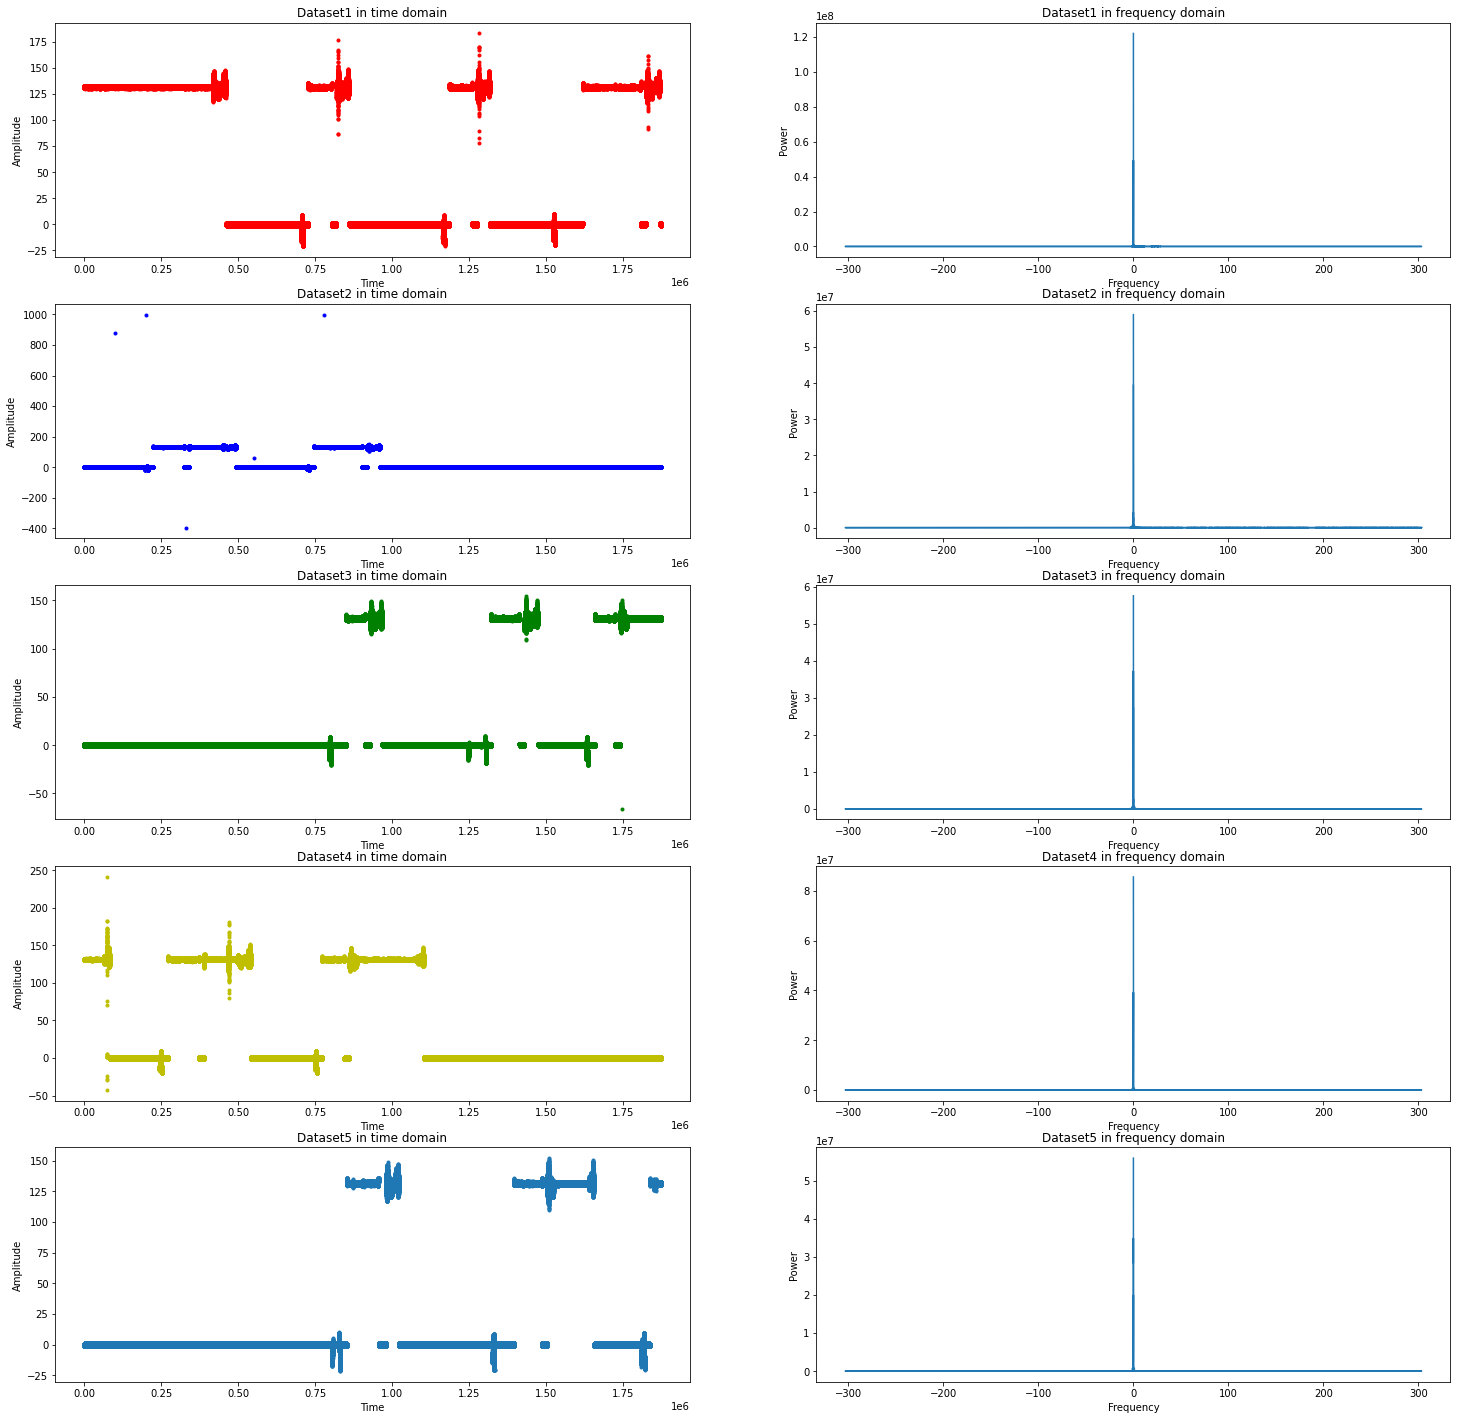

In [22]:
fig, axs = plt.subplots(5,2)
fig.set_figwidth(25)
fig.set_figheight(25)

axs[0][0].plot(data1[:,1], 'r.')
axs[0][0].set_title('Dataset1 in time domain')
xf,yf = fftransform(data1[:,1])
axs[0][1].plot(xf, np.abs(yf))
axs[0][1].set_title('Dataset1 in frequency domain')

axs[1][0].plot(data2[:,1], 'b.')
axs[1][0].set_title('Dataset2 in time domain')
xf,yf = fftransform(data2[:,1])
axs[1][1].plot(xf, np.abs(yf))
axs[1][1].set_title('Dataset2 in frequency domain')

axs[2][0].plot(data3[:,1], 'g.')
axs[2][0].set_title('Dataset3 in time domain')
xf,yf = fftransform(data3[:,1])
axs[2][1].plot(xf, np.abs(yf))
axs[2][1].set_title('Dataset3 in frequency domain')

axs[3][0].plot(data4[:,1], 'y.')
axs[3][0].set_title('Dataset4 in time domain')
xf,yf = fftransform(data4[:,1])
axs[3][1].plot(xf, np.abs(yf))
axs[3][1].set_title('Dataset4 in frequency domain')

axs[4][0].plot(data5[:,1], '.')
axs[4][0].set_title('Dataset5 in time domain')
xf,yf = fftransform(data5[:,1])
axs[4][1].plot(xf, np.abs(yf))
axs[4][1].set_title('Dataset5 in frequency domain')

for ax in axs[:,0].flat:
    ax.set(xlabel='Time', ylabel='Amplitude')
for ax in axs[:,1].flat:
    ax.set(xlabel='Frequency', ylabel='Power')


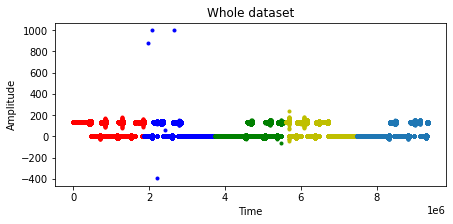

In [23]:
# VISUALIZE THE WHOLE DATASET
vis(whole[:,1],'Whole dataset') # I indicated the different cvs files with different colours

# Filtering


In [24]:
# https://docs.scipy.org/doc/scipy/reference/signal.html
# There are a lot of different filters with different effects in this page. I just tried few ones.

whole_sav = savgol_filter(whole[:,1], 5, 2)
whole_med = scipy.signal.medfilt(whole[:,1],333)

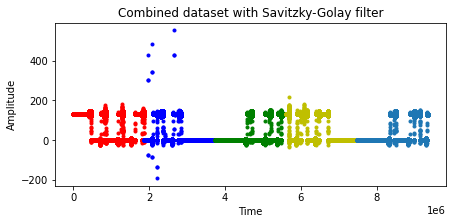

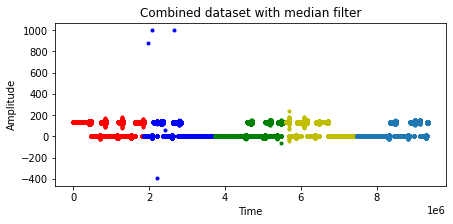

In [25]:
vis(whole_sav, 'Combined dataset with Savitzky-Golay filter')
vis(whole_med, 'Combined dataset with median filter')

# Feature Vector Creation
In signal processing usually we use feature vectors to describe a given signal. First we divide the signal into smaller windows, and then store some main characteristics of this small windows in the feature vectors.
I decided to calculate the following three basic features: 


*   The range of amplitude in which the signal variates, that is the difference between the maximum
peak and the minimum
*   The maximum or the minimum value that the signals reach, depending on if the maximum
absolute is positive or negative
*   The average of every signal window

As an experiment, I tried K-Means clustering on the feature vectors. This could work as a pattern recognition as well, because we can see that it differentiate the higher values from the lowers. So if I would find the the borders between the labels, I could define these ones as a pattern.

In [26]:
sample_number = 2000
N = math.floor(whole.shape[0]/sample_number)                                    #I checked how many windows can I create with this window size = 2000
windows = np.array(np.split(whole[0:sample_number*N,:], N))                     #I discarded the  'uncomplete windows' (in the end of the dataset)
windows_amp = np.squeeze(windows[:,:,1])                                        #I only kept the amplitude values

AVERAGE = np.mean(windows_amp, axis=1)                                          #calculate average value
MAXIMUM = np.max(windows_amp, axis = 1)
MINIMUM = np.min(windows_amp, axis = 1)

for i in range(windows_amp.shape[0]):                                           #calculate the maximum value (or minimum if it is negative)
  if np.abs(MAXIMUM[i]) > np.abs(MINIMUM[i]):
    MAXIMUM[i] = MAXIMUM[i]
  else:
    MAXIMUM[i] = MINIMUM[i]
RANGE = np.max(windows_amp, axis = 1)-np.min(windows_amp,axis = 1)              #calculate the difference between the higest and lowest value

feature_vectors = np.vstack((AVERAGE, MAXIMUM,RANGE)).T                         #concatenate the features to a matrix

In [27]:
# K-MEANS
kmeans = KMeans(n_clusters=2).fit(feature_vectors)
labels = kmeans.labels_

labels_whole = np.zeros(N*sample_number)
for i in range(N):
  for j in range(sample_number):
    labels_whole[i*2000+j] = labels[i]

Text(0.5, 0, 'Time')

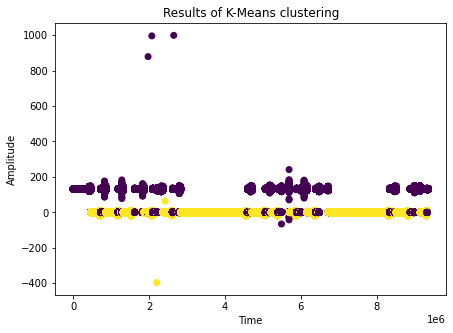

In [28]:
fig = plt.figure()
fig.set_figwidth(7)
fig.set_figheight(5)
plt.scatter(np.arange(labels_whole.shape[0]), whole[0:sample_number*N,1], c=labels_whole)
plt.title('Results of K-Means clustering')
plt.ylabel('Amplitude')
plt.xlabel('Time')

# Replace Outstanding Values
In the figures we can see that there are some outsanding values in the dataset which are much bigger or smaller then the other ones. I can detect them with a simple threshold and then I can replace the values with interpolation.

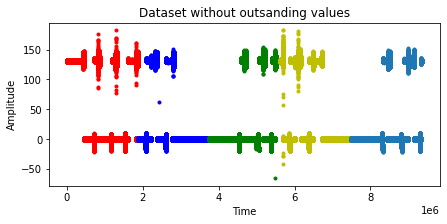

In [31]:
w = whole[:,1]
filtered1 = (w > 200)                                           # filter the amplitudes which are bigger than 200
filtered2 = (w < -200)                                          # filter the amplitudes which are smaller than -200
w[filtered1] = np.nan
w[filtered2] = np.nan
df = pd.DataFrame(w)
df = df.apply(pd.to_numeric)
df = df.interpolate(method='polynomial', order=2)               # replace the eliminated values with interpolated values
data_eliminated = df.to_numpy()

vis(data_eliminated, 'Dataset without outsanding values')

# Finding peaks

There is a function for finding peaks in python. With different parameter settings 'different kind of peaks' could be found. 


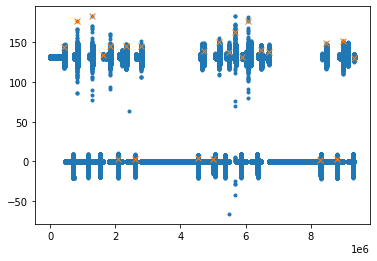

In [30]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

peaks, _ = find_peaks(whole[:,1], threshold = 5 , distance = 150000)
peaks_with_timestamps = whole[peaks,:]                                          # the list with peaks and the corresponding timestamps
plt.plot(whole[:,1],'.')
plt.plot(peaks, whole[peaks,1], "x")